In [1]:
import tensorflow as tf
import numpy as np
import uuid
import matplotlib.pyplot as plt

# np.random.seed(2018)

m = 2 # dimension
k_sq = 0.04
learning_rate = 0.001
epochs = 10000
batch_size = 100
x_stddev = 25
activation_fn_1 = tf.nn.sigmoid
activation_fn = tf.nn.sigmoid
num_units_1 = 150
num_units_2 = 30
decay = 1 - 10*1e-10
# decay = 0.001

test_averaging = 100
num_test_intervals = 40 # how many intervals to divide the test space into
num_test_points = num_test_intervals**m# how many test points across all spaces are evaluated

# Allow a batch of values to work
x0 = tf.placeholder(tf.float32, [None, m])
z = tf.placeholder(tf.float32, [None, m])

l1 = tf.layers.dense(
  x0, num_units_1, activation=activation_fn_1, use_bias=True)
l2 = tf.layers.dense(
  l1, m, activation=tf.identity, use_bias=True)

u1 = l2
u1_cost = (tf.norm(u1)**2) / batch_size

# The observed value for the second controller is the original controlled with noise
x1 = x0 + u1
y1 = x1 + z

l3 = tf.layers.dense(
  y1, num_units_2, activation=activation_fn, use_bias=True)
l4 = tf.layers.dense(
  l3, m, activation=tf.identity, use_bias=True)

u2 = -l4
x2 = x1 + u2

u2_cost = (tf.norm(x2) ** 2) / batch_size
wits_cost = (k_sq * u1_cost) + u2_cost

adaptive_learning_rate = tf.placeholder_with_default(learning_rate, [])

optimizer = tf.train.GradientDescentOptimizer(
  learning_rate=adaptive_learning_rate).minimize(wits_cost)

init_op = tf.global_variables_initializer()

tf.summary.scalar("WITS Cost", wits_cost)
merged_summary_op = tf.summary.merge_all()



INFO:tensorflow:Summary name WITS Cost is illegal; using WITS_Cost instead.


In [2]:
with tf.Session() as sess:
  sess.run(init_op)
  uniq_id = "/tmp/tensorboard-layers-api/" + uuid.uuid1().__str__()[:6]
  summary_writer = tf.summary.FileWriter(uniq_id, graph=tf.get_default_graph())
  x_train = np.random.normal(size=epochs * batch_size * m, scale=x_stddev)

  # Train for some epochs
  for step in range(epochs):
    x_batch = x_train[step: step + (batch_size * m)].reshape((batch_size, m))

    # Noise has variance 1
    z_batch = np.random.normal(size=(batch_size, m), scale=1)

    _, val, summary = sess.run(
      [optimizer, wits_cost, merged_summary_op],
      feed_dict={x0: x_batch, z: z_batch,
                 adaptive_learning_rate: learning_rate * (decay**step)})

    if step % 10 == 0:
      print("step: {}, value: {}".format(step, val))
      summary_writer.add_summary(summary, step)
  

  # Test over a continuous range of X
#   x0_test=np.array(np.meshgrid
#                    (np.linspace(-2*x_stddev, 2*x_stddev, num=num_test_intervals),
#                     np.linspace(-2*x_stddev, 2*x_stddev, num=num_test_intervals)))
  x0_test=np.array(np.meshgrid
                   (np.linspace(-15, 15, num=num_test_intervals),
                    np.linspace(-15, 15, num=num_test_intervals)))
#   u1_test, u2_test, x1_test = np.zeros((m, num_test_points)), np.zeros((m, num_test_points)), np.zeros((m, num_test_points))
  u1_test = np.array(np.meshgrid(np.zeros(num_test_intervals), np.zeros(num_test_intervals)))
  u2_test = np.array(np.meshgrid(np.zeros(num_test_intervals), np.zeros(num_test_intervals)))
  x1_test = np.array(np.meshgrid(np.zeros(num_test_intervals), np.zeros(num_test_intervals)))

    
  for i in range(num_test_intervals):
    for j in range(num_test_intervals):
        u1t, u2t, x1t = 0, 0, 0
        for _ in range(test_averaging):
          x0_current_test = np.array([x0_test[0,i,j], x0_test[1,i,j]])
          u1tmp, u2tmp, x1tmp = sess.run(
                [u1, u2, x1], # return these variables
                feed_dict={x0: x0_current_test.reshape((1, 2)), z: np.random.normal(
                  size=(1, 2), scale=1)})

          u1t += u1tmp
          u2t += u2tmp
          x1t += x1tmp

        u1_test[0, i,j], u1_test[1,i,j] = u1t[0,0] / test_averaging, u1t[0,1]/ test_averaging
        u2_test[0, i,j], u2_test[1,i,j] = -u2t[0,0] / test_averaging, -u2t[0,1]/ test_averaging
        x1_test[0, i,j], x1_test[1,i,j] = x1t[0,0] / test_averaging, x1t[0,1]/ test_averaging

step: 0, value: 1128.55322265625
step: 10, value: 595.9097290039062
step: 20, value: 437.4405212402344
step: 30, value: 311.73480224609375
step: 40, value: 251.2565460205078
step: 50, value: 221.8306884765625
step: 60, value: 196.4831085205078
step: 70, value: 165.3204803466797
step: 80, value: 148.818359375
step: 90, value: 133.25721740722656
step: 100, value: 125.81658172607422
step: 110, value: 119.06571197509766
step: 120, value: 108.57582092285156
step: 130, value: 115.15486145019531
step: 140, value: 121.669189453125
step: 150, value: 133.84832763671875
step: 160, value: 126.92306518554688
step: 170, value: 126.23172760009766
step: 180, value: 120.66163635253906
step: 190, value: 117.45289611816406
step: 200, value: 96.77720642089844
step: 210, value: 108.02862548828125
step: 220, value: 94.52088165283203
step: 230, value: 88.66961669921875
step: 240, value: 88.24586486816406
step: 250, value: 85.17913818359375
step: 260, value: 84.46827697753906
step: 270, value: 89.619720458984

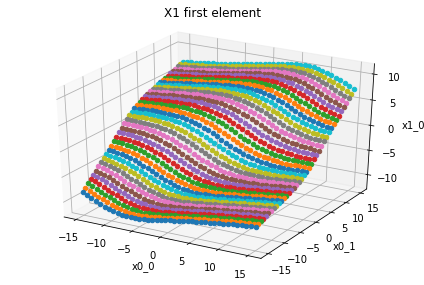

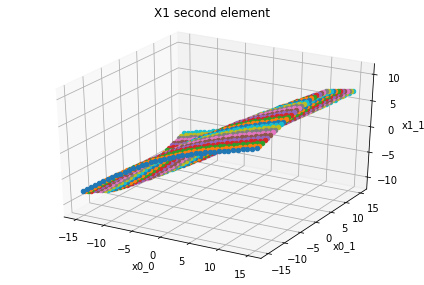

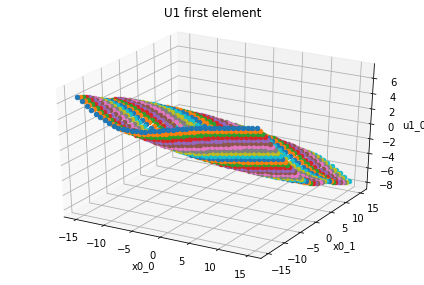

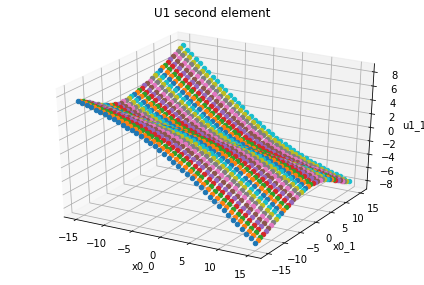

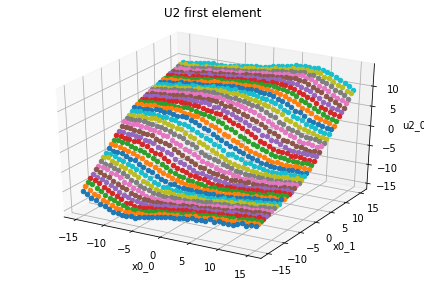

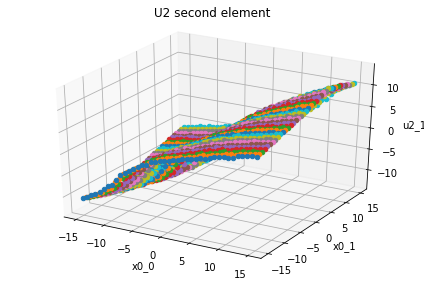

In [4]:
from mpl_toolkits.mplot3d import Axes3D
x_axis = np.linspace(-15, 15, num=num_test_intervals)
y_axis = np.linspace(-15, 15, num=num_test_intervals)

# PLOT X1_0
fig = plt.figure()
fig.suptitle('X1 first element')
ax = fig.gca(projection='3d')
for i in range(num_test_intervals):
    for j in range(num_test_intervals):
        ax.scatter(x_axis[i], y_axis[j], x1_test[0,i,j])
ax.set_xlabel('x0_0')
ax.set_ylabel('x0_1')
ax.set_zlabel('x1_0')
plt.tight_layout()
plt.show()

# PLOT X1_1
fig = plt.figure()
fig.suptitle('X1 second element')
ax = fig.gca(projection='3d')
for i in range(num_test_intervals):
    for j in range(num_test_intervals):
        ax.scatter(x_axis[i], y_axis[j], x1_test[1,i,j])
ax.set_xlabel('x0_0')
ax.set_ylabel('x0_1')
ax.set_zlabel('x1_1')
plt.tight_layout()
plt.show()

# PLOT U1_0
fig = plt.figure()
fig.suptitle('U1 first element')
ax = fig.gca(projection='3d')
for i in range(num_test_intervals):
    for j in range(num_test_intervals):
        ax.scatter(x_axis[i], y_axis[j], u1_test[0,i,j])
ax.set_xlabel('x0_0')
ax.set_ylabel('x0_1')
ax.set_zlabel('u1_0')
plt.tight_layout()
plt.show()

# PLOT U1_1
fig = plt.figure()
fig.suptitle('U1 second element')
ax = fig.gca(projection='3d')
for i in range(num_test_intervals):
    for j in range(num_test_intervals):
        ax.scatter(x_axis[i], y_axis[j], u1_test[1,i,j])
ax.set_xlabel('x0_0')
ax.set_ylabel('x0_1')
ax.set_zlabel('u1_1')
plt.tight_layout()
plt.show()

# PLOT U2_0
fig = plt.figure()
fig.suptitle('U2 first element')
ax = fig.gca(projection='3d')
for i in range(num_test_intervals):
    for j in range(num_test_intervals):
        ax.scatter(x_axis[i], y_axis[j], u2_test[0,i,j])
ax.set_xlabel('x0_0')
ax.set_ylabel('x0_1')
ax.set_zlabel('u2_0')
plt.tight_layout()
plt.show()

# PLOT U2_1
fig = plt.figure()
fig.suptitle('U2 second element')
ax = fig.gca(projection='3d')
for i in range(num_test_intervals):
    for j in range(num_test_intervals):
        ax.scatter(x_axis[i], y_axis[j], u2_test[1,i,j])
ax.set_xlabel('x0_0')
ax.set_ylabel('x0_1')
ax.set_zlabel('u2_1')
plt.tight_layout()
plt.show()